In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('...', session=session)

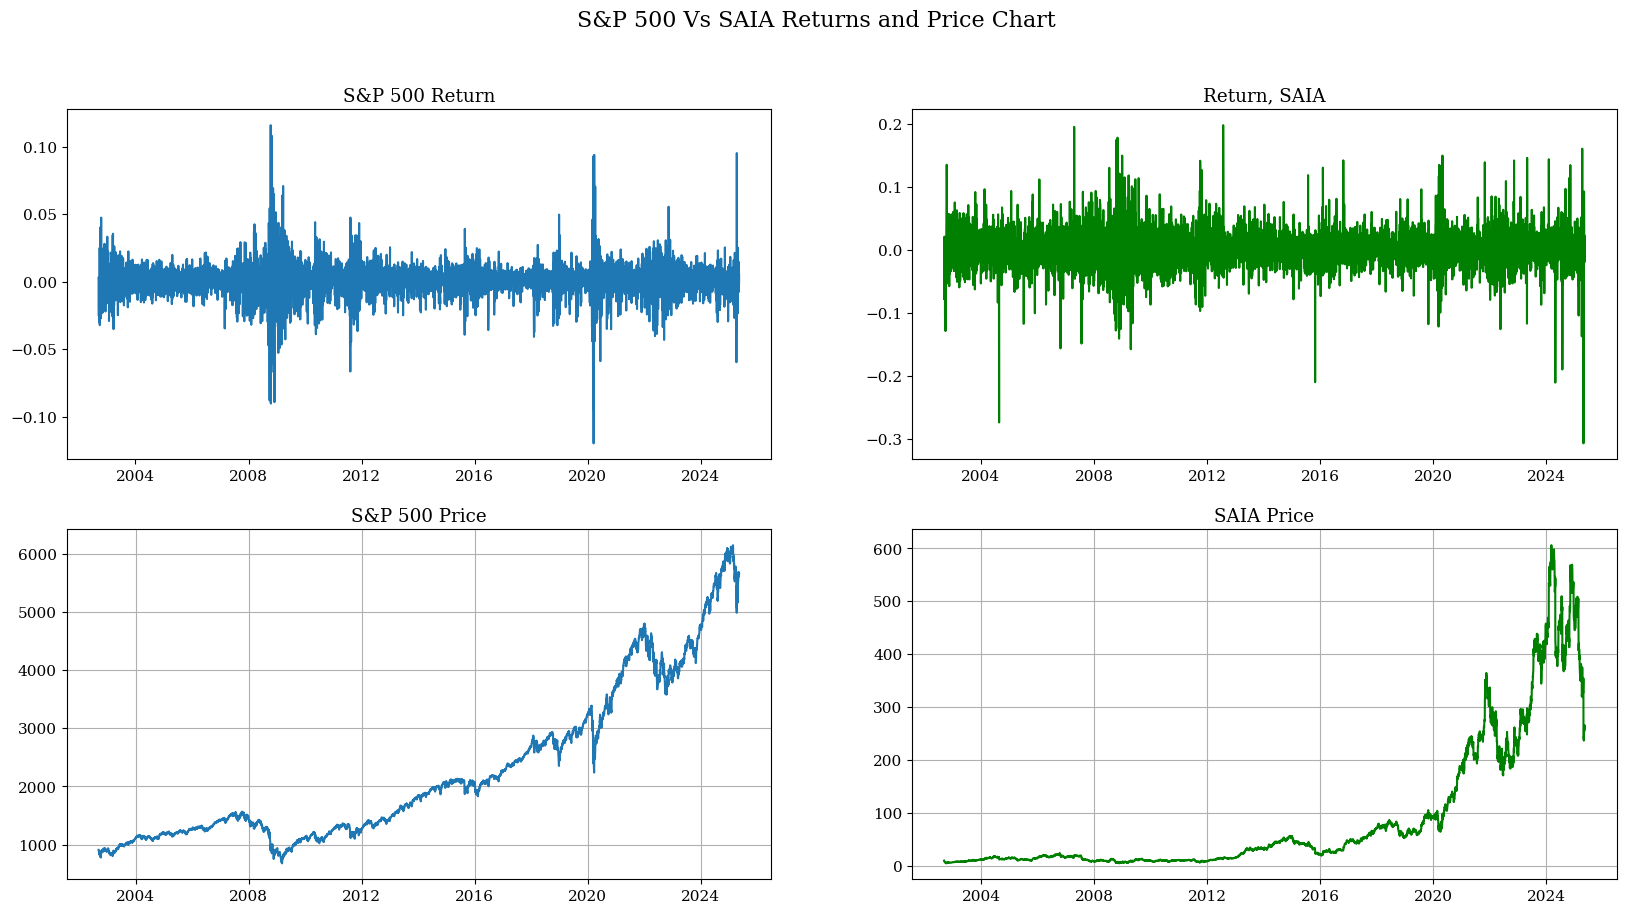

In [3]:

get_input = input("Enter a stock Ticker: ")
T = yf.Ticker(get_input)
stock_history = T.history(period="max")
stock_history.index = stock_history.index.tz_localize(None)
stock_history['Date'] = stock_history.index
stock_history = stock_history.reset_index(drop=True)
stock_history = stock_history.drop(['Open', "High", "Low", "Volume","Dividends", "Stock Splits"], axis = 1)

min_date = stock_history['Date'].min()
max_date = stock_history['Date'].max()

I = yf.Ticker("^GSPC")
index_history = I.history(start = min_date)
index_history.index = index_history.index.tz_localize(None)
index_history['Date'] = index_history.index
index_history = index_history.reset_index(drop=True)
index_history = index_history.drop(['Open', "High", "Low", "Volume","Dividends", "Stock Splits"], axis = 1)
index_history

combo = stock_history.merge(index_history, left_on='Date', right_on='Date')
combo[['Close_x', 'Close_y']] = combo[['Close_x', 'Close_y']].pct_change()
combo["Date"] = combo['Date']
combo = combo.dropna().reset_index(drop=True)

combo1 = stock_history.merge(index_history, left_on='Date', right_on='Date')

plt.rcParams.update({'font.size': 11, 'font.family' : 'DeJavu Serif'})
plt.rcParams['font.serif'] = ['Times New Roman']



fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].plot(combo['Date'], combo['Close_y'])
ax[0,0].set_title("S&P 500 Return")
ax[0,1].set_title("Return, " + get_input)
ax[0,1].plot(combo['Date'], combo['Close_x'],color = 'Green')
ax[1,0].plot(combo1['Date'], combo1['Close_y'])
ax[1,0].set_title("S&P 500 Price")
ax[1,0].grid(True)
ax[1,1].plot(combo1['Date'], combo1['Close_x'],color = 'Green')
ax[1,1].set_title(get_input+" Price")
ax[1,1].grid(True)
plt.suptitle("S&P 500 Vs " + get_input + " Returns and Price Chart", fontsize=16)
plt.show()

#for stock info
# for k,v in T.info.items():
#     print (k, '\t', v, '\n')

In [4]:
# # for stock info
# for k,v in T.info.items():
#     print (k, '\t', v, '\n')

In [5]:
# Normalize the index 
# combo1["Normal_Index"] = combo1.iloc[:,-1] / combo1.iloc[0,-1]
# combo1["Normal_Stock"] = combo1.iloc[:,0] / combo1.iloc[0,0]
# fig2, ax =  plt.subplots(figsize=(15,6))
# ax.plot(combo1["Date"] , combo1["Normal_Stock"], color='Green')
# ax.plot(combo1["Date"] , combo1["Normal_Index"], color='Blue')

In [6]:
starting_date = input("Enter a starting Date: ")
try:
    u = ((datetime.strptime(starting_date,"%m-%d-%Y" )))#.strftime('%m/%d/%Y')
except:
    print("Enter a valid date formate MM-DD-YYYY")
    u = 0

In [7]:
if u==0:
    print("Anything cannot be done untill correct date is entered")
else:
  combo1 = combo1[(combo1['Date']<=starting_date)]
  combo = combo[(combo['Date']<=starting_date)]
  #Getting monthly returns
  combo_monthly = ((combo1["Date"].groupby(combo1['Date'].dt.to_period('M')).max()).values)
  combo_monthly = (combo1[combo1['Date'].isin(combo_monthly)]).reset_index(drop=True)
  combo_monthly[['Close_x','Close_y']] = combo_monthly[['Close_x','Close_y']].pct_change()
  combo_monthly = combo_monthly.dropna().reset_index(drop=True)
  #Getting weekly returns
  combo_weekly = ((combo1["Date"].groupby(combo1['Date'].dt.to_period('W')).max()).values)
  combo_weekly = (combo1[combo1['Date'].isin(combo_weekly)]).reset_index(drop=True)
  combo_weekly[['Close_x','Close_y']] = combo_weekly[['Close_x','Close_y']].pct_change()
  combo_weekly = combo_weekly.dropna().reset_index(drop=True)


In [8]:
from dateutil.relativedelta import relativedelta
#Setting up dates
starting_date_dt = datetime.strptime(starting_date, "%m-%d-%Y")
x = 5
date = starting_date_dt - relativedelta(years=x)
date_limit = min_date + relativedelta(years=x)
# combo_weekly = combo_weekly[(combo_weekly['Date']>=date_limit)]
#
#
#
#
# 5-Year weekly
c = combo_weekly[(combo_weekly['Date']>=date - relativedelta(days=0))].index[0]

beta = [np.polyfit(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0],1)]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
  beta.append(np.polyfit(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0],1))

cor = [np.corrcoef(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0])[0][1]]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
  cor.append(np.corrcoef(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0])[0][1])
cor_weekly = pd.DataFrame(cor)
beta5year_weekly = pd.DataFrame(beta)
beta5year_weekly['Date'] = (combo_weekly[(combo_weekly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)
beta5year_weekly["weekly_correlation"] = cor_weekly
beta5year_weekly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)

#
#
#
#
# 5-Year Montly
c = combo_monthly[(combo_monthly['Date']>=date - relativedelta(days=0))].index[0]
beta1 = [np.polyfit(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0],1)]
for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
  beta1.append(np.polyfit(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0],1))

cor1 = [(np.corrcoef(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
  cor1.append(np.corrcoef(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0])[0][1])
cor_monthly = pd.DataFrame(cor1)

beta5year_monthly = pd.DataFrame(beta1)
beta5year_monthly['Date'] = (combo_monthly[(combo_monthly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta5year_monthly["monthly_correlation"] = cor_monthly
beta5year_monthly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)


#
#
#
#
# 5-Year Daily
c = combo[(combo['Date']>=date - relativedelta(days=0))].index[0]

beta2 = [np.polyfit(combo.iloc[c+1:,-1], combo.iloc[c+1:,0],1)]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
  beta2.append(np.polyfit(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0],1))


cor2 = [(np.corrcoef(combo.iloc[c+1:,-1], combo.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
  cor2.append(np.corrcoef(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0])[0][1])
cor_daily = pd.DataFrame(cor2)

beta5year_daily = pd.DataFrame(beta2)
beta5year_daily['Date'] = (combo[(combo['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta5year_daily["daily_correlation"] = cor_daily
beta5year_daily.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)

In [9]:
#Setting up dates
starting_date_dt = datetime.strptime(starting_date, "%m-%d-%Y")
x = 4
date = starting_date_dt - relativedelta(years=x)
date_limit = min_date + relativedelta(years=x)
# combo_weekly = combo_weekly[(combo_weekly['Date']>=date_limit)]




# 4-Year weekly
# beta 04 means weekly return for 4 years
c = combo_weekly[(combo_weekly['Date']>=date - relativedelta(days=0))].index[0]

beta04 = [np.polyfit(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0],1)]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
  beta04.append(np.polyfit(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0],1))

cor04 = [np.corrcoef(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0])[0][1]]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
  cor04.append(np.corrcoef(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0])[0][1])

cor_weekly04 = pd.DataFrame(cor04)
beta4year_weekly = pd.DataFrame(beta04)
beta4year_weekly['Date'] = (combo_weekly[(combo_weekly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)
beta4year_weekly["weakly_correlation"] = cor_weekly04
beta4year_weekly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)

#
#
#
#
# 4-Year monthly
c = combo_monthly[(combo_monthly['Date']>=date - relativedelta(days=0))].index[0]
beta14 = [np.polyfit(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0],1)]
for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
  beta14.append(np.polyfit(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0],1))

cor14 = [(np.corrcoef(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
  cor14.append(np.corrcoef(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0])[0][1])

cor_monthly14 = pd.DataFrame(cor14)

beta4year_monthly = pd.DataFrame(beta14)
beta4year_monthly['Date'] = (combo_monthly[(combo_monthly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta4year_monthly["monthly_correlation"] = cor_monthly14
beta4year_monthly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)
beta4year_monthly

#
#
#
#
#
# 4 - Years daily
c = combo[(combo['Date']>=date - relativedelta(days=0))].index[0]

beta24 = [np.polyfit(combo.iloc[c+1:,-1], combo.iloc[c+1:,0],1)]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
  beta24.append(np.polyfit(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0],1))


cor24 = [(np.corrcoef(combo.iloc[c+1:,-1], combo.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
  cor24.append(np.corrcoef(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0])[0][1])
cor_daily24 = pd.DataFrame(cor24)

beta4year_daily = pd.DataFrame(beta24)
beta4year_daily['Date'] = (combo[(combo['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta4year_daily["daily_correlation"] = cor_daily24
beta4year_daily.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)


In [10]:
starting_date_dt = datetime.strptime(starting_date, "%m-%d-%Y")
x = 3
date = starting_date_dt - relativedelta(years=x)
date_limit = min_date + relativedelta(years=x)
# combo_weekly = combo_weekly[(combo_weekly['Date']>=date_limit)]

#
#
#
# 3-Year weekly
# beta 03 means weekly return for 3 years
c = combo_weekly[(combo_weekly['Date']>=date - relativedelta(days=0))].index[0]

beta03 = [np.polyfit(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0],1)]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
    beta03.append(np.polyfit(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0],1))

cor03 = [np.corrcoef(combo_weekly.iloc[c+1:,-1], combo_weekly.iloc[c+1:,0])[0][1]]

for i in range(1,len(combo_weekly[(combo_weekly['Date']>date_limit)]),1):
  cor03.append(np.corrcoef(combo_weekly.iloc[c+1-i:-i,-1], combo_weekly.iloc[c+1-i:-i,0])[0][1])

cor_weekly03 = pd.DataFrame(cor03)
beta3year_weekly = pd.DataFrame(beta03)
beta3year_weekly['Date'] = (combo_weekly[(combo_weekly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)
beta3year_weekly["weakly_correlation"] = cor_weekly03
beta3year_weekly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)
#
#
#
#
#
# 3 - Years monthly
c = combo_monthly[(combo_monthly['Date']>=date - relativedelta(days=0))].index[0]
beta13 = [np.polyfit(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0],1)]
for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
  beta13.append(np.polyfit(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0],1))

cor13 = [(np.corrcoef(combo_monthly.iloc[c+1:,-1], combo_monthly.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo_monthly[(combo_monthly['Date']>date_limit)]),1):
    cor13.append(np.corrcoef(combo_monthly.iloc[c+1-i:-i,-1], combo_monthly.iloc[c+1-i:-i,0])[0][1])

cor_monthly13 = pd.DataFrame(cor13)

beta3year_monthly = pd.DataFrame(beta13)
beta3year_monthly['Date'] = (combo_monthly[(combo_monthly['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta3year_monthly["monthly_correlation"] = cor_monthly13
beta3year_monthly.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)
beta3year_monthly

#
#
#
#
#
# 3 - Years daily

c = combo[(combo['Date']>=date - relativedelta(days=0))].index[0]

beta23 = [np.polyfit(combo.iloc[c+1:,-1], combo.iloc[c+1:,0],1)]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
  beta23.append(np.polyfit(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0],1))


cor23 = [(np.corrcoef(combo.iloc[c+1:,-1], combo.iloc[c+1:,0])[0][1])]

for i in range(1,len(combo[(combo['Date']>date_limit)]),1):
    cor23.append(np.corrcoef(combo.iloc[c+1-i:-i,-1], combo.iloc[c+1-i:-i,0])[0][1])
    
cor_daily23 = pd.DataFrame(cor23)

beta3year_daily = pd.DataFrame(beta23)
beta3year_daily['Date'] = (combo[(combo['Date']>date_limit)].iloc[:,1]).sort_values(ascending=False).reset_index(drop=True)

beta3year_daily["daily_correlation"] = cor_daily23
beta3year_daily.rename(columns={0: 'Beta', 1: 'Intercept'}, inplace=True)


In [11]:
beta5year_daily

,Beta,Intercept,Date,daily_correlation
0,1.416237,0.000445,2025-05-08,0.514708
1,1.419258,0.000459,2025-05-07,0.515594
2,1.417384,0.000431,2025-05-06,0.515160
3,1.416911,0.000438,2025-05-05,0.515031
4,1.419565,0.000482,2025-05-02,0.515169
...,...,...,...,...
4438,1.206898,0.000224,2007-09-18,0.365377
4439,1.197314,0.000192,2007-09-17,0.361682
4440,1.202477,0.000177,2007-09-14,0.364436
4441,1.205761,0.000132,2007-09-13,0.364662


In [12]:
beta5year_weekly

,Beta,Intercept,Date,weekly_correlation
0,1.331589,0.002007,2025-05-08,0.509001
1,1.339542,0.002045,2025-05-02,0.512322
2,1.330507,0.002438,2025-04-25,0.505294
3,1.423058,0.003684,2025-04-17,0.557972
4,1.405606,0.003191,2025-04-11,0.550508
...,...,...,...,...
917,1.715038,0.001079,2007-10-12,0.434538
918,1.629659,0.000827,2007-10-05,0.416491
919,1.697699,0.000191,2007-09-28,0.429476
920,1.728538,-0.000235,2007-09-21,0.435385


In [13]:
beta5year_monthly

,Beta,Intercept,Date,monthly_correlation
0,2.018576,0.001799,2025-05-08,0.661562
1,2.037100,0.002008,2025-04-30,0.665628
2,1.990347,0.007435,2025-03-31,0.699111
3,1.897044,0.010707,2025-02-28,0.698014
4,1.786781,0.016719,2025-01-31,0.685470
...,...,...,...,...
208,1.270179,-0.000523,2008-01-31,0.279566
209,1.322659,0.000292,2007-12-31,0.273458
210,0.984049,0.005979,2007-11-30,0.213814
211,0.818758,0.006561,2007-10-31,0.177411


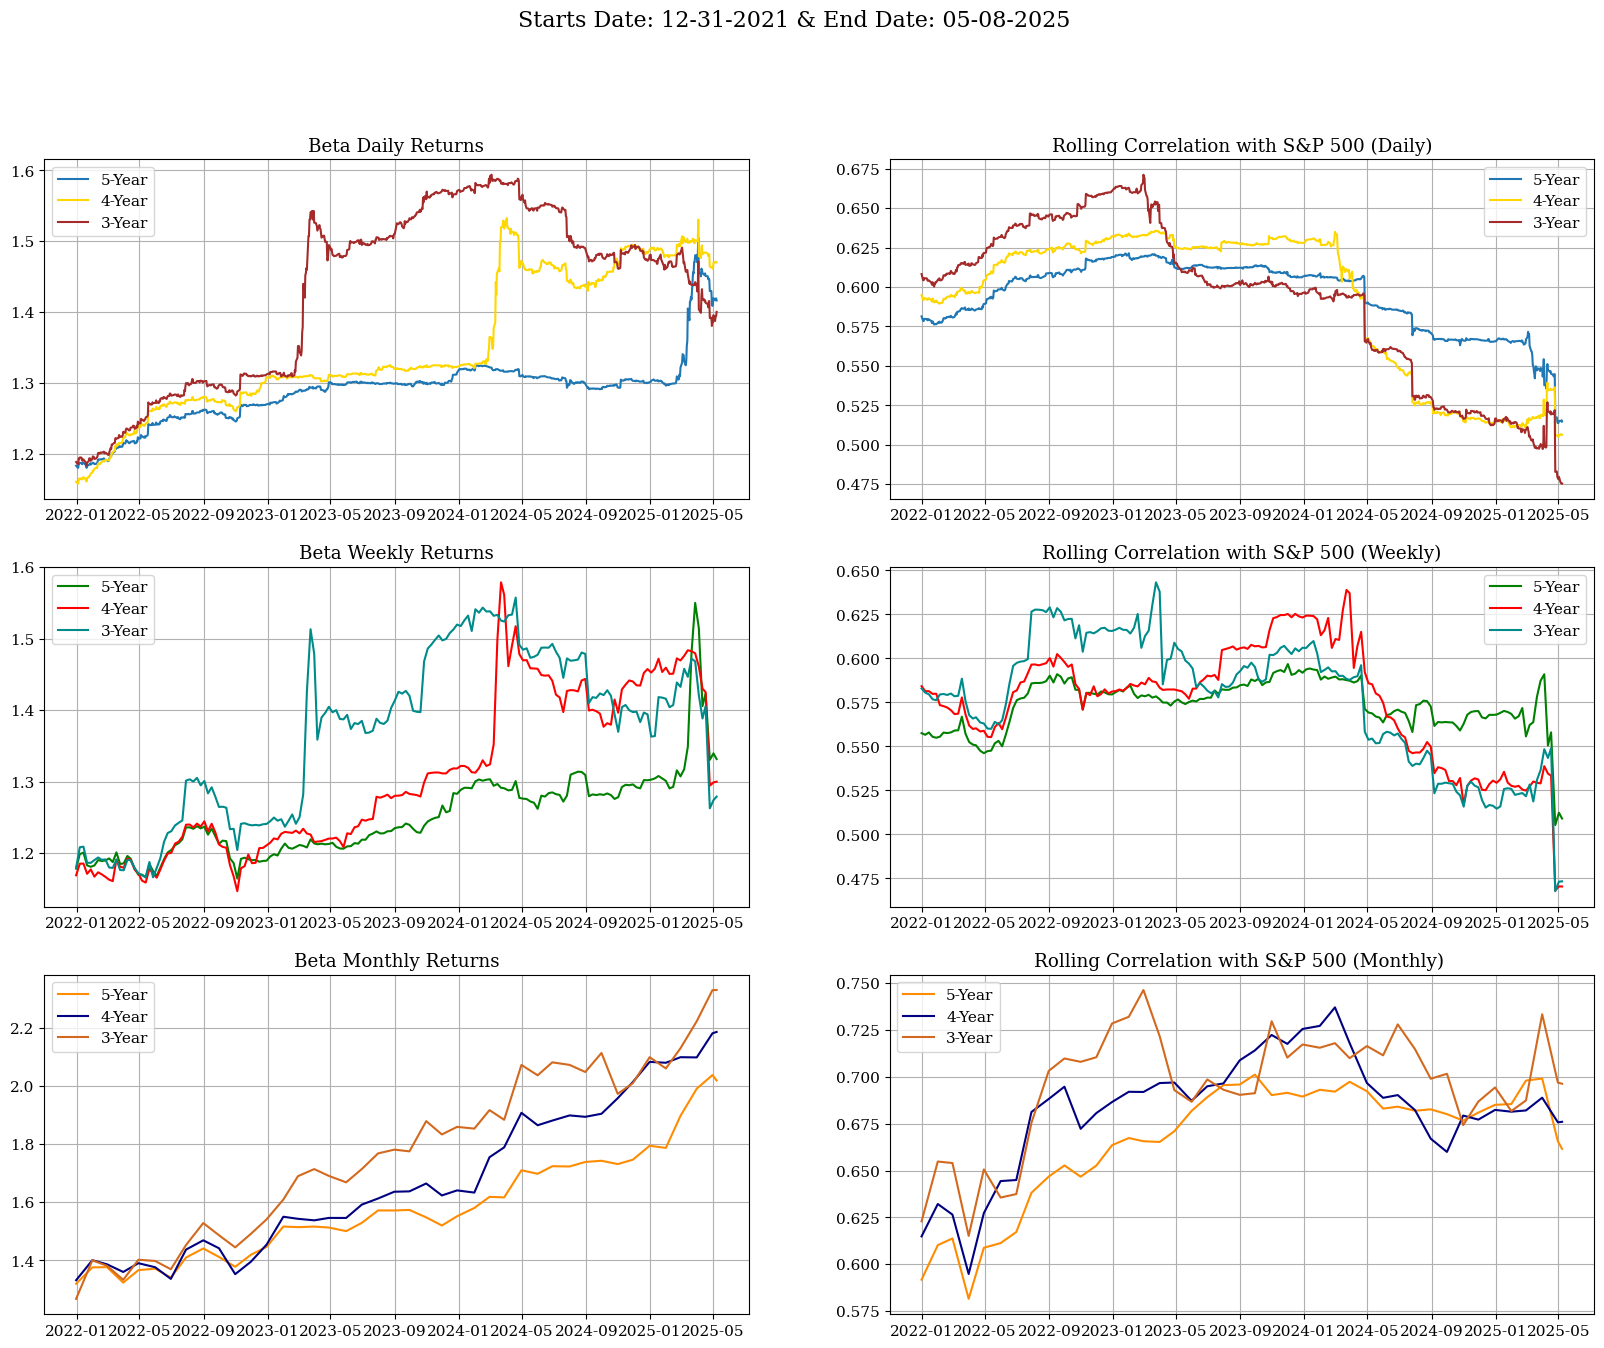

In [14]:
#Different Value of time can be entered here 

starting_date_dt = datetime.strptime("12-31-2021", "%m-%d-%Y")
date = starting_date_dt

fig1, ax = plt.subplots(3,2,figsize=(20,15))

plt.rcParams.update({'font.size': 11, 'font.family' : 'DeJavu Serif'})
plt.rcParams['font.serif'] = ['Times New Roman']

ax[0,0].plot(beta5year_daily[beta5year_daily["Date"] >= date].iloc[:,2], beta5year_daily[beta5year_daily["Date"] >= date].iloc[:,0], label = '5-Year')
ax[0,0].plot(beta4year_daily[beta4year_daily["Date"] >= date].iloc[:,2], beta4year_daily[beta4year_daily["Date"] >= date].iloc[:,0], label = '4-Year',color='gold')
ax[0,0].plot(beta3year_daily[beta3year_daily["Date"] >= date].iloc[:,2], beta3year_daily[beta3year_daily["Date"] >= date].iloc[:,0], label = '3-Year',color='Brown')
ax[0,0].legend()
ax[0,0].set_title("Beta Daily Returns")
ax[0,0].grid(True)

ax[0,1].plot(beta5year_daily[beta5year_daily["Date"] >= date].iloc[:,2], beta5year_daily[beta5year_daily["Date"] >= date].iloc[:,-1], label = '5-Year')
ax[0,1].plot(beta4year_daily[beta4year_daily["Date"] >= date].iloc[:,2], beta4year_daily[beta4year_daily["Date"] >= date].iloc[:,-1], label = '4-Year',color='gold')
ax[0,1].plot(beta3year_daily[beta3year_daily["Date"] >= date].iloc[:,2], beta3year_daily[beta3year_daily["Date"] >= date].iloc[:,-1], label = '3-Year',color='Brown')
ax[0,1].legend()
ax[0,1].set_title("Rolling Correlation with S&P 500 (Daily)")
ax[0,1].grid(True)

ax[1,0].plot(beta5year_weekly[beta5year_weekly["Date"] >= date].iloc[:,2], beta5year_weekly[beta5year_weekly["Date"] >= date].iloc[:,0], color='Green', label = '5-Year')
ax[1,0].plot(beta4year_weekly[beta4year_weekly["Date"] >= date].iloc[:,2], beta4year_weekly[beta4year_weekly["Date"] >= date].iloc[:,0],color='Red', label = '4-Year')
ax[1,0].plot(beta3year_weekly[beta3year_weekly["Date"] >= date].iloc[:,2], beta3year_weekly[beta3year_weekly["Date"] >= date].iloc[:,0],color='darkcyan', label = '3-Year')
ax[1,0].legend()
ax[1,0].set_title("Beta Weekly Returns")
ax[1,0].grid(True)

ax[1,1].plot(beta5year_weekly[beta5year_weekly["Date"] >= date].iloc[:,2], beta5year_weekly[beta5year_weekly["Date"] >= date].iloc[:,-1], color='Green', label = '5-Year')
ax[1,1].plot(beta4year_weekly[beta4year_weekly["Date"] >= date].iloc[:,2], beta4year_weekly[beta4year_weekly["Date"] >= date].iloc[:,-1],color='Red', label = '4-Year')
ax[1,1].plot(beta3year_weekly[beta3year_weekly["Date"] >= date].iloc[:,2], beta3year_weekly[beta3year_weekly["Date"] >= date].iloc[:,-1],color='darkcyan', label = '3-Year')
ax[1,1].legend()
ax[1,1].set_title("Rolling Correlation with S&P 500 (Weekly)")
ax[1,1].grid(True)

ax[2,0].plot(beta5year_monthly[beta5year_monthly["Date"] >= date].iloc[:,2], beta5year_monthly[beta5year_monthly["Date"] >= date].iloc[:,0], color='darkorange', label = '5-Year')
ax[2,0].plot(beta4year_monthly[beta4year_monthly["Date"] >= date].iloc[:,2], beta4year_monthly[beta4year_monthly["Date"] >= date].iloc[:,0],color='navy', label = '4-Year')
ax[2,0].plot(beta3year_monthly[beta3year_monthly["Date"] >= date].iloc[:,2], beta3year_monthly[beta3year_monthly["Date"] >= date].iloc[:,0],color='chocolate', label = '3-Year')
ax[2,0].legend()
ax[2,0].set_title("Beta Monthly Returns")
ax[2,0].grid(True)

ax[2,1].plot(beta5year_monthly[beta5year_monthly["Date"] >= date].iloc[:,2], beta5year_monthly[beta5year_monthly["Date"] >= date].iloc[:,-1], color='darkorange', label = '5-Year')
ax[2,1].plot(beta4year_monthly[beta4year_monthly["Date"] >= date].iloc[:,2], beta4year_monthly[beta4year_monthly["Date"] >= date].iloc[:,-1],color='navy', label = '4-Year')
ax[2,1].plot(beta3year_monthly[beta3year_monthly["Date"] >= date].iloc[:,2], beta3year_monthly[beta3year_monthly["Date"] >= date].iloc[:,-1],color='chocolate', label = '3-Year')
ax[2,1].legend()
ax[2,1].set_title("Rolling Correlation with S&P 500 (Monthly) ")
ax[2,1].grid(True)

plt.suptitle("Starts Date: " + date.strftime('%m-%d-%Y') + " & " + "End Date: " + starting_date, fontsize=16)
plt.show()

In [15]:
# ## Remove the comments if you want to transfer everything into excel file 
with pd.ExcelWriter("Returns, Beta and Correlation.xlsx") as writer:
    combo1.to_excel(writer, sheet_name = 'Prices', index= False)
    combo.to_excel(writer, sheet_name = 'Daily Returns', index= False)
    combo_monthly.to_excel(writer, sheet_name = 'Monthly Returns', index= False)
    combo_weekly.to_excel(writer, sheet_name = 'Weekly Returns', index= False)
    beta3year_monthly.to_excel(writer, sheet_name = '3-Yr Monthly', index= False)
    beta3year_weekly.to_excel(writer, sheet_name = '3-Yr Weekly', index= False)
    beta3year_daily.to_excel(writer, sheet_name = '3-Yr Daily', index= False)
    #
    beta4year_monthly.to_excel(writer, sheet_name = '4-Yr Monthly', index= False)
    beta4year_weekly.to_excel(writer, sheet_name = '4-Yr Weekly', index= False)
    beta4year_daily.to_excel(writer, sheet_name = '4-Yr Daily', index= False)
    #
    beta5year_monthly.to_excel(writer, sheet_name = '5-Yr Monthly', index= False)
    beta5year_weekly.to_excel(writer, sheet_name = '5-Yr Weekly', index= False)
    beta5year_daily.to_excel(writer, sheet_name = '5-Yr Daily', index= False)
    #
fig1.savefig('Beta and Correlation.png')
fig.savefig('Return.png')

fig1.savefig('Beta and Correlation.png')    

    

        